In [48]:
# 🔬 Activation Function Benchmark (Jupyter Notebook)
# ---------------------------------------------------------------
# Goal: Compare activation functions (ReLU / Sigmoid / Tanh / GELU / SiLU(Swish) / LeakyReLU, etc.)
# on a simple NLP classification task.
#
# Idea:
# - Since we cannot change the activation functions inside GPT itself, 
#   we experiment with a small custom classification model.
# - Use the same dataset, same architecture, and same training setup, 
#   while varying only the activation function.
# - Workflow: Text → SBERT embeddings → (sklearn) train/test split → 
#   (PyTorch) Dataset/DataLoader → MLP with chosen activation → 
#   train/evaluate with Accuracy, F1, ROC AUC, etc.

In [45]:
"""
Workflow: End-to-End Experiment Pipeline

Text Embedding (SBERT)
Convert raw documents into dense vector embeddings using Sentence-BERT.
Data Split (scikit-learn)
Split embeddings and labels into train/validation/test sets using train_test_split.
Dataset & DataLoader (PyTorch)
Wrap data into a custom Dataset.
Use DataLoader for efficient mini-batch training.
Activation Registry
Define a dictionary of activation functions (ReLU, GELU, Mish, etc.) to allow easy switching.
Model Building
Build an MLP model with configurable hidden dimensions and activation.
Training & Evaluation
Train the model on training data.
Evaluate with accuracy, F1, AUC on validation/test sets.
Collect results for comparison across activation functions.
"""

'\nWorkflow: End-to-End Experiment Pipeline\n\nText Embedding (SBERT)\n\nConvert raw documents into dense vector embeddings using Sentence-BERT.\n\nData Split (scikit-learn)\n\nSplit embeddings and labels into train/validation/test sets using train_test_split.\n\nDataset & DataLoader (PyTorch)\n\nWrap data into a custom Dataset.\n\nUse DataLoader for efficient mini-batch training.\n\nActivation Registry\n\nDefine a dictionary of activation functions (ReLU, GELU, Mish, etc.) to allow easy switching.\n\nModel Building\n\nBuild an MLP model with configurable hidden dimensions and activation.\n\nTraining & Evaluation\n\nTrain the model on training data.\n\nEvaluate with accuracy, F1, AUC on validation/test sets.\n\nCollect results for comparison across activation functions.\n'

In [47]:
"""
Modular Style

SBERT Embedding

sklearn split

Dataset/DataLoader

Model-related code

ACTIVATIONS registry

build_model(...)

train_model(...)

evaluate(...)

Final train/eval execution
"""

'\nModular Style\n\nSBERT Embedding\n\nsklearn split\n\nDataset/DataLoader\n\nModel-related code\n\nACTIVATIONS registry\n\nbuild_model(...)\n\ntrain_model(...)\n\nevaluate(...)\n\nFinal train/eval execution\n'

In [3]:
# -------------------------------
# Standard Library
# -------------------------------
import math
import time
import random
from dataclasses import dataclass
from typing import Dict, List

# -------------------------------
# Core Data/ML Libraries
# -------------------------------
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------------
# Sklearn Utilities
# -------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt

# -------------------------------
# NLP Embedding Model
# -------------------------------
from sentence_transformers import SentenceTransformer


In [4]:
# -------------------------------
# Device Setup
# -------------------------------
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

DEVICE_STR = str(DEVICE)  # always a string: "cuda", "mps", or "cpu"
print("Using device:", DEVICE_STR)

# Optional: improve precision on newer GPUs
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

Using device: mps


In [5]:
# -------------------------------
# Data Loading (20 Newsgroups)
# -------------------------------
print("All categories:")
print(fetch_20newsgroups(subset="train").target_names)


All categories:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [49]:
# Restrict dataset to 2 categories: Medical vs. Space
CATEGORIES = ["sci.med", "sci.space"]

# Load the dataset (remove headers, footers, and quotes for cleaner input text)
raw = fetch_20newsgroups(
    subset="all",
    categories=CATEGORIES,
    remove=("headers", "footers", "quotes")
)

In [52]:
# Define features (text) and labels
X_text = raw.data
y = raw.target.astype(np.int64)


In [53]:
# Define features (text) and labels
X_text = raw.data
y = raw.target.astype(np.int64)

In [54]:
# Quick sanity check
print("Number of documents:", len(X_text))
print("Unique labels:", np.unique(y))
print("Target names:", raw.target_names)

Number of documents: 1977
Unique labels: [0 1]
Target names: ['sci.med', 'sci.space']


In [55]:
# Show first 3 documents (truncated)
for i in range(3):
    print(f"\nDoc {i} (label={y[i]} -> {raw.target_names[y[i]]})")
    print(X_text[i][:300], "...")


Doc 0 (label=0 -> sci.med)





Cute anecdote, but hardly indicative of the population.  From the responses
I've received to that post (all from men, by the way) I get the impression
that unless a person is willing to drop down and masturbate whenever the
need or desire strikes, then that person is very hung up on sex.

With  ...

Doc 1 (label=1 -> sci.space)


You should have heard Prof. McNally , from my days as an astronomy
undergraduate, denouncing photon pollution. It was easy to imagine him
taking practical steps to modify the sodium lamps on the street
outside Mill Hill observatory with a 12-gauge shotgun :-)

However, seriously, it is possible to ...

Doc 2 (label=1 -> sci.space)

  Did the Russian spacecraft(s) on the ill-fated Phobos mission a few
years ago send back any images of the Martian moon?  If so, does anyone know if
they're housed at an ftp site?
  Thanks.
 
 ...


In [56]:
print(len(X_text), "documents")

1977 documents


In [57]:
print(raw.target_names)  # ['sci.med', 'sci.space']

['sci.med', 'sci.space']


In [59]:
# Separate into each category for quick inspection
med_docs = [doc for doc, label in zip(X_text, y) if raw.target_names[label] == "sci.med"]
space_docs = [doc for doc, label in zip(X_text, y) if raw.target_names[label] == "sci.space"]

In [61]:
print("Sample sci.med doc:", med_docs[0][:300], "...")
print("Sample sci.space doc:", space_docs[0][:300], "...")

Sample sci.med doc: 




Cute anecdote, but hardly indicative of the population.  From the responses
I've received to that post (all from men, by the way) I get the impression
that unless a person is willing to drop down and masturbate whenever the
need or desire strikes, then that person is very hung up on sex.

With  ...
Sample sci.space doc: 

You should have heard Prof. McNally , from my days as an astronomy
undergraduate, denouncing photon pollution. It was easy to imagine him
taking practical steps to modify the sodium lamps on the street
outside Mill Hill observatory with a 12-gauge shotgun :-)

However, seriously, it is possible to ...


In [62]:
# -------------------------------
# Vectorize text using Sentence-BERT
# -------------------------------
from sentence_transformers import SentenceTransformer

model_name = "all-MiniLM-L6-v2"   # 384-dimensional embeddings, fast and decent performance
sbert = SentenceTransformer(model_name, device=DEVICE_STR)
# Save embeddings and labels to disk as .npy files 
np.save("sbert_X.npy", X)
np.save("labels.npy", y)

# Reload embeddings and labels from .npy files 
# (useful to skip Sentence-BERT encoding step on later runs)
X = np.load("sbert_X.npy")
y = np.load("labels.npy")
X = sbert.encode(
    X_text,
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=32
)
X.shape  # (N, 384)

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

(1977, 384)

In [63]:
# Save embeddings and labels to disk as .npy files 
np.save("sbert_X.npy", X)
np.save("labels.npy", y)

# Reload embeddings and labels from .npy files 
# (useful to skip Sentence-BERT encoding step on later runs)
X = np.load("sbert_X.npy")
y = np.load("labels.npy")

In [64]:
# -------------------------------
# Step 3: Wrap into Dataset & DataLoader
# -------------------------------

# Custom PyTorch Dataset wrapper for our news data
class NewsDataset(Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays into PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        # Return the total number of samples
        return len(self.X)
    def __getitem__(self, idx):
        # Return a single sample (features, label)
        return self.X[idx], self.y[idx]


In [65]:
# Use sklearn to split into train / validation / test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,        # 30% goes to temp (val+test)
    random_state=42,      # reproducibility
    stratify=y            # preserve class balance
)

In [66]:
# Split the temp set equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,        # half of 30% → 15% test, 15% val
    random_state=42,
    stratify=y_temp
)

In [67]:
# -------------------------------
# Step 4: Build Dataset & DataLoader
# -------------------------------

# Wrap the numpy splits into our custom Dataset class
train_ds = NewsDataset(X_train, y_train)
val_ds   = NewsDataset(X_val, y_val)
test_ds  = NewsDataset(X_test, y_test)


In [68]:
# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)  # smaller batch, shuffle for training
val_loader   = DataLoader(val_ds, batch_size=64)                  # larger batch, no shuffle needed
test_loader  = DataLoader(test_ds, batch_size=64)                 # for final evaluation|

In [69]:
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))

Train/Val/Test sizes: 1383 297 297


In [70]:
# Peek at one mini-batch to verify tensor shapes
xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, yb.shape) 

Train batch: torch.Size([32, 384]) torch.Size([32])


In [71]:
xbv, ybv = next(iter(val_loader))
print("Val batch:  ", xbv.shape, ybv.shape)

Val batch:   torch.Size([64, 384]) torch.Size([64])


In [72]:
xbt, ybt = next(iter(test_loader))
print("Test batch: ", xbt.shape, ybt.shape)

Test batch:  torch.Size([64, 384]) torch.Size([64])


In [25]:
#모델 관련 (ACTIVATIONS, build_model, evaluate, train)

In [26]:
# -------------------------------
# Activations registry
# -------------------------------
ACTIVATIONS = {
    "relu": nn.ReLU(),
    "leaky_relu": nn.LeakyReLU(0.01),
    "prelu": nn.PReLU(),
    "gelu": nn.GELU(),
    "silu": nn.SiLU(),        # Swish
    "hardswish": nn.Hardswish(),
    "elu": nn.ELU(),
    "selu": nn.SELU(),
    "tanh": nn.Tanh(),
    "sigmoid": nn.Sigmoid(),
    "softplus": nn.Softplus(),
    "softsign": nn.Softsign(),
    "hardtanh": nn.Hardtanh(),
    "mish": nn.Mish(),
}

In [73]:
# -------------------------------
# MLP & Builder
# -------------------------------
class MLP(nn.Module):
    """A simple 2-layer MLP: input -> hidden(activation) -> logits(2 classes)."""
    def __init__(self, input_dim: int, hidden_dim: int, activation_fn: nn.Module):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def build_model(act_name: str, input_dim: int, hidden_dim: int = 128) -> MLP:
    """
    Build an MLP with a chosen activation function (from ACTIVATIONS registry).
    """
    key = act_name.lower()
    if key not in ACTIVATIONS:
        raise ValueError(f"Unknown activation: {act_name}. Available: {list(ACTIVATIONS.keys())}")
    return MLP(input_dim=input_dim, hidden_dim=hidden_dim, activation_fn=ACTIVATIONS[key])



In [74]:
# -------------------------------
# Evaluation (concise, Jupyter-friendly)
# -------------------------------
@torch.no_grad()
def evaluate(model: nn.Module, loader, device: torch.device, verbose: bool = True) -> dict:
    """
    Evaluate on a given DataLoader and return {loss, acc, f1, auc}.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss, total_n = 0.0, 0
    all_probs, all_preds, all_labels = [], [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = criterion(logits, yb)

        probs  = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        preds  = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = yb.detach().cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels)

        total_loss += loss.item() * xb.size(0)
        total_n    += xb.size(0)

    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except Exception:
        auc = float("nan")

    metrics = {"loss": total_loss / max(total_n, 1), "acc": acc, "f1": f1, "auc": auc}

    if verbose:
        print(
            "[Eval]",
            f"loss={metrics['loss']:.4f}",
            f"acc={metrics['acc']:.4f}",
            f"f1={metrics['f1']:.4f}",
            f"auc={(metrics['auc'] if isinstance(metrics['auc'], float) else float('nan')):.4f}",
        )
    return metrics


In [75]:
# -------------------------------
# Training (concise)
# -------------------------------
def train_model(
    act_name: str = "relu",
    hidden_dim: int = 128,
    epochs: int = 4,
    lr: float = 1e-3,
):
    """
    Train one model with the chosen activation, then evaluate on test set.
    Returns:
        model (nn.Module), test_metrics (dict)
    """
    input_dim = X_train.shape[1]
    device    = DEVICE

    model = build_model(act_name, input_dim, hidden_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        total_loss, total_n = 0.0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_n    += xb.size(0)

        train_loss = total_loss / max(total_n, 1)
        val_metrics = evaluate(model, val_loader, device, verbose=False)
        print(f"[Epoch {ep:02d}] loss={train_loss:.4f} | val_acc={val_metrics['acc']:.4f} val_auc={val_metrics['auc']:.4f}")

    test_metrics = evaluate(model, test_loader, device, verbose=True)
    return model, test_metrics


In [78]:
_, test_metrics = train_model(
    act_name="relu",
    hidden_dim=128,
    epochs=4,
    lr=1e-3
)
test_metrics

[Epoch 01] loss=0.5384 | val_acc=0.9158 val_auc=0.9814
[Epoch 02] loss=0.2006 | val_acc=0.9158 val_auc=0.9841
[Epoch 03] loss=0.1273 | val_acc=0.9125 val_auc=0.9831
[Epoch 04] loss=0.1096 | val_acc=0.9057 val_auc=0.9816
[Eval] loss=0.1672 acc=0.9192 f1=0.9200 auc=0.9822


{'loss': 0.16718979395599878,
 'acc': 0.9191919191919192,
 'f1': 0.92,
 'auc': 0.982201160892436}

In [92]:
# Benchmarking different activation functions (single run per activation)
import pandas as pd
import random, numpy as np, torch

# Utility: fix random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [93]:
# Run training with different activations and collect test metrics
def benchmark_activations(names, hidden_dim=128, epochs=4, lr=1e-3, sort_by="auc"):
    rows = []
    for name in names:
        print(f"\n=== {name} ===")
        set_seed(42)  # fairness: reset seed for each run
        _, m = train_model(act_name=name, hidden_dim=hidden_dim, epochs=epochs, lr=lr)
        rows.append({"activation": name, **m})
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)
    
    # Optional: sort results by the specified metric (default = AUC)
    if sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=False).reset_index(drop=True)
    return df


In [94]:
#List of candidate activation functions to benchmark
ACT_LIST = [
    "relu", "leaky_relu", "prelu", "gelu", "silu", "hardswish",
    "elu", "selu", "tanh", "sigmoid", "softplus", "softsign",
    "hardtanh", "mish"
]

# Run the benchmark and display results as a DataFrame (Jupyter will render a table)
results = benchmark_activations(ACT_LIST, hidden_dim=128, epochs=4, lr=1e-3, sort_by="auc")
results


=== relu ===
[Epoch 01] loss=0.5265 | val_acc=0.9192 val_auc=0.9815
[Epoch 02] loss=0.1985 | val_acc=0.9226 val_auc=0.9838
[Epoch 03] loss=0.1277 | val_acc=0.9158 val_auc=0.9830
[Epoch 04] loss=0.1070 | val_acc=0.9125 val_auc=0.9820
[Eval] loss=0.1646 acc=0.9226 f1=0.9236 auc=0.9825

=== leaky_relu ===
[Epoch 01] loss=0.5234 | val_acc=0.9192 val_auc=0.9815
[Epoch 02] loss=0.1962 | val_acc=0.9226 val_auc=0.9839
[Epoch 03] loss=0.1273 | val_acc=0.9158 val_auc=0.9830
[Epoch 04] loss=0.1069 | val_acc=0.9125 val_auc=0.9819
[Eval] loss=0.1647 acc=0.9226 f1=0.9236 auc=0.9826

=== prelu ===
[Epoch 01] loss=0.4091 | val_acc=0.9226 val_auc=0.9819
[Epoch 02] loss=0.1440 | val_acc=0.9158 val_auc=0.9834
[Epoch 03] loss=0.1118 | val_acc=0.9125 val_auc=0.9822
[Epoch 04] loss=0.0959 | val_acc=0.9192 val_auc=0.9815
[Eval] loss=0.1700 acc=0.9226 f1=0.9236 auc=0.9829

=== gelu ===
[Epoch 01] loss=0.5485 | val_acc=0.9192 val_auc=0.9797
[Epoch 02] loss=0.2344 | val_acc=0.9192 val_auc=0.9825
[Epoch 03] los

,activation,loss,acc,f1,auc
0,selu,0.167655,0.922559,0.923588,0.983108
1,prelu,0.169953,0.922559,0.923588,0.982927
2,elu,0.164283,0.919192,0.920530,0.982927
3,tanh,0.164274,0.919192,0.920530,0.982836
4,softsign,0.164784,0.919192,0.920530,0.982836
5,hardtanh,0.164286,0.919192,0.920530,0.982791
6,leaky_relu,0.164676,0.922559,0.923588,0.982609
7,relu,0.164623,0.922559,0.923588,0.982473
8,silu,0.165067,0.922559,0.924092,0.982428
9,mish,0.164427,0.922559,0.924092,0.982383


In [90]:
# ----------------------------------------
# Run multiple repeats for more robust evaluation
# ----------------------------------------
def benchmark_with_repeats(
    names, repeats=3, hidden_dim=128, epochs=4, lr=1e-3, sort_by="auc_mean"
):
    rows = []
    for name in names:
        print(f"\n=== {name} (repeats={repeats}) ===")
        metrics_list = []

        # Repeat training several times with different seeds
        for r in range(repeats):
            set_seed(42 + r)  # Ensure reproducibility across runs
            _, m = train_model(act_name=name, hidden_dim=hidden_dim, epochs=epochs, lr=lr)
            metrics_list.append(m)

        # Aggregate results across repeats (mean ± std)
        dfm = pd.DataFrame(metrics_list)
        rows.append({
            "activation": name,
            "loss_mean": dfm["loss"].mean(), "loss_std": dfm["loss"].std(),
            "acc_mean":  dfm["acc"].mean(),  "acc_std":  dfm["acc"].std(),
            "f1_mean":   dfm["f1"].mean(),   "f1_std":   dfm["f1"].std(),
            "auc_mean":  dfm["auc"].mean(),  "auc_std":  dfm["auc"].std(),
        })
    # Collect results into a summary DataFrame
    out = pd.DataFrame(rows)

    # Optionally sort by a specific metric (default: auc_mean)
    if sort_by in out.columns:
        out = out.sort_values(by=sort_by, ascending=False).reset_index(drop=True)
    return out


In [95]:
results_rep = benchmark_with_repeats(ACT_LIST, repeats=3, hidden_dim=128, epochs=4, lr=1e-3, sort_by="auc_mean")
results_rep


=== relu (repeats=3) ===
[Epoch 01] loss=0.5265 | val_acc=0.9192 val_auc=0.9815
[Epoch 02] loss=0.1985 | val_acc=0.9226 val_auc=0.9838
[Epoch 03] loss=0.1277 | val_acc=0.9158 val_auc=0.9830
[Epoch 04] loss=0.1070 | val_acc=0.9125 val_auc=0.9820
[Eval] loss=0.1646 acc=0.9226 f1=0.9236 auc=0.9825
[Epoch 01] loss=0.5377 | val_acc=0.9158 val_auc=0.9808
[Epoch 02] loss=0.1985 | val_acc=0.9192 val_auc=0.9829
[Epoch 03] loss=0.1276 | val_acc=0.9125 val_auc=0.9831
[Epoch 04] loss=0.1066 | val_acc=0.9091 val_auc=0.9824
[Eval] loss=0.1641 acc=0.9259 f1=0.9247 auc=0.9829
[Epoch 01] loss=0.5273 | val_acc=0.9192 val_auc=0.9811
[Epoch 02] loss=0.1976 | val_acc=0.9125 val_auc=0.9836
[Epoch 03] loss=0.1277 | val_acc=0.9192 val_auc=0.9830
[Epoch 04] loss=0.1099 | val_acc=0.9057 val_auc=0.9826
[Eval] loss=0.1620 acc=0.9259 f1=0.9247 auc=0.9831

=== leaky_relu (repeats=3) ===
[Epoch 01] loss=0.5234 | val_acc=0.9192 val_auc=0.9815
[Epoch 02] loss=0.1962 | val_acc=0.9226 val_auc=0.9839
[Epoch 03] loss=0.1

,activation,loss_mean,loss_std,acc_mean,acc_std,f1_mean,f1_std,auc_mean,auc_std
0,selu,0.165250,0.003053,0.922559,0.000000,0.921837,0.001516,0.983426,0.000276
1,elu,0.163167,0.001740,0.923681,0.003888,0.923282,0.002383,0.983153,0.000227
2,tanh,0.163075,0.001793,0.922559,0.003367,0.922050,0.002269,0.983138,0.000277
3,softsign,0.163343,0.002005,0.923681,0.003888,0.923282,0.002383,0.983138,0.000277
4,hardtanh,0.163128,0.001748,0.922559,0.003367,0.922050,0.002269,0.983078,0.000295
5,prelu,0.167715,0.003166,0.921437,0.001944,0.920597,0.003189,0.983033,0.000159
6,leaky_relu,0.163593,0.001420,0.923681,0.001944,0.923069,0.001902,0.982881,0.000252
7,relu,0.163587,0.001390,0.924804,0.001944,0.924301,0.000617,0.982813,0.000312
8,mish,0.164023,0.000749,0.923681,0.001944,0.923588,0.001885,0.982685,0.000319
9,silu,0.164835,0.000497,0.923681,0.001944,0.923588,0.001885,0.982640,0.000228


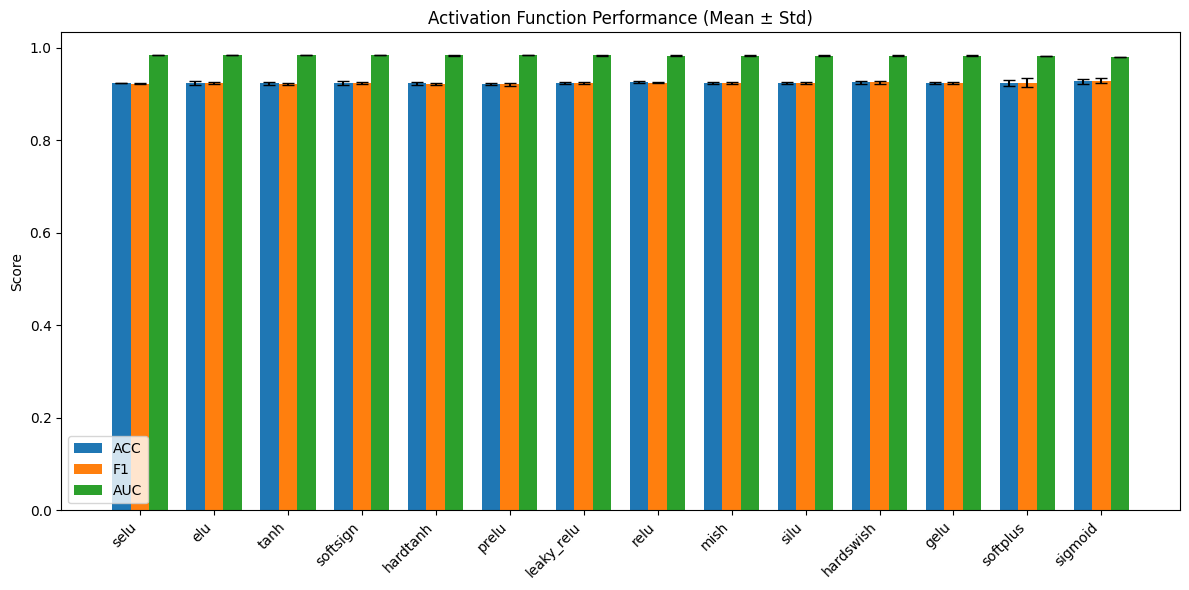

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# DataFrame이 results_rep라고 가정 (이미 만들어둔 표)
metrics = ["acc_mean", "f1_mean", "auc_mean"]
errors  = ["acc_std", "f1_std", "auc_std"]

x = np.arange(len(results_rep))  # x축 index
width = 0.25                     # 막대 폭

fig, ax = plt.subplots(figsize=(12,6))

for i, (m, e) in enumerate(zip(metrics, errors)):
    ax.bar(x + i*width,
           results_rep[m],
           width,
           yerr=results_rep[e],
           capsize=4,
           label=m.replace("_mean","").upper())

ax.set_xticks(x + width)
ax.set_xticklabels(results_rep["activation"], rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Activation Function Performance (Mean ± Std)")
ax.legend()
plt.tight_layout()
plt.show()


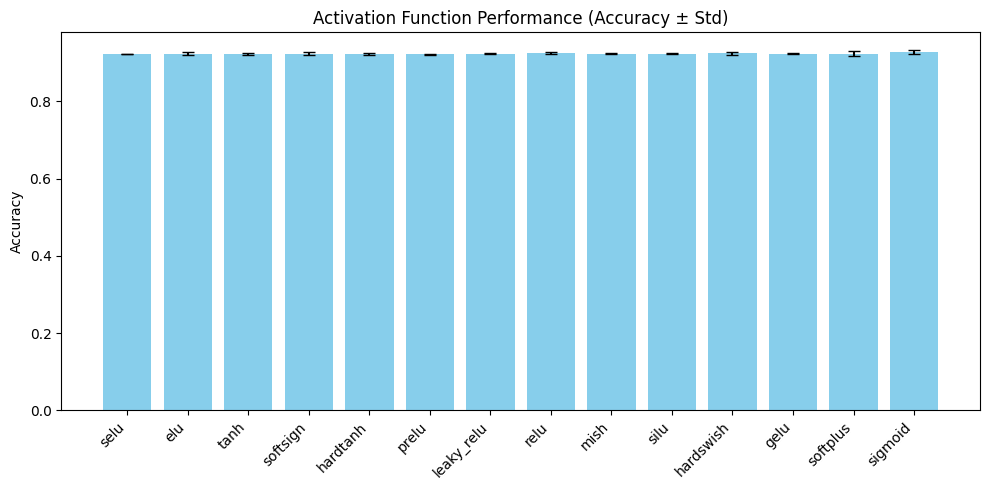

In [97]:
import matplotlib.pyplot as plt

# activation vs acc_mean ± acc_std
plt.figure(figsize=(10,5))
plt.bar(results_rep["activation"],
        results_rep["acc_mean"],
        yerr=results_rep["acc_std"],
        capsize=4,
        color="skyblue")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Activation Function Performance (Accuracy ± Std)")
plt.tight_layout()
plt.show()


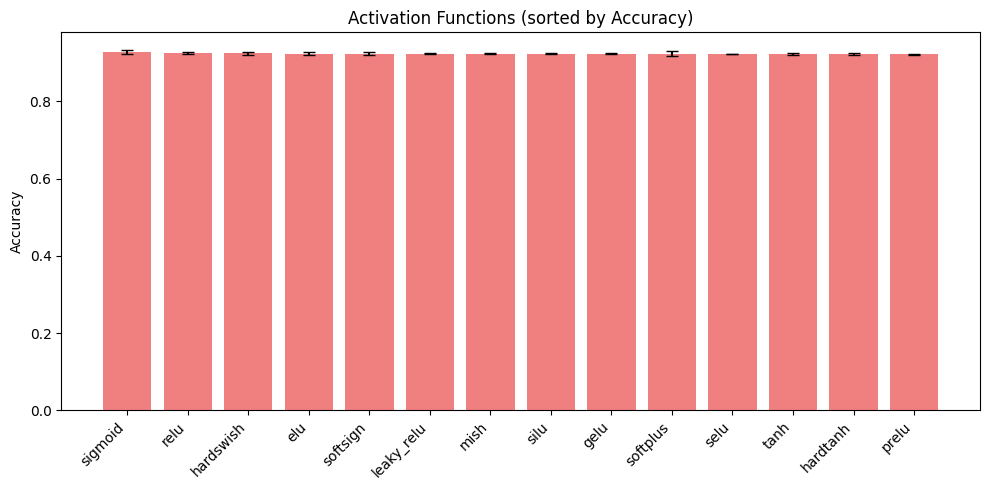

In [98]:
df_sorted = results_rep.sort_values("acc_mean", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(df_sorted["activation"], df_sorted["acc_mean"],
        yerr=df_sorted["acc_std"], capsize=4, color="lightcoral")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Activation Functions (sorted by Accuracy)")
plt.tight_layout()
plt.show()

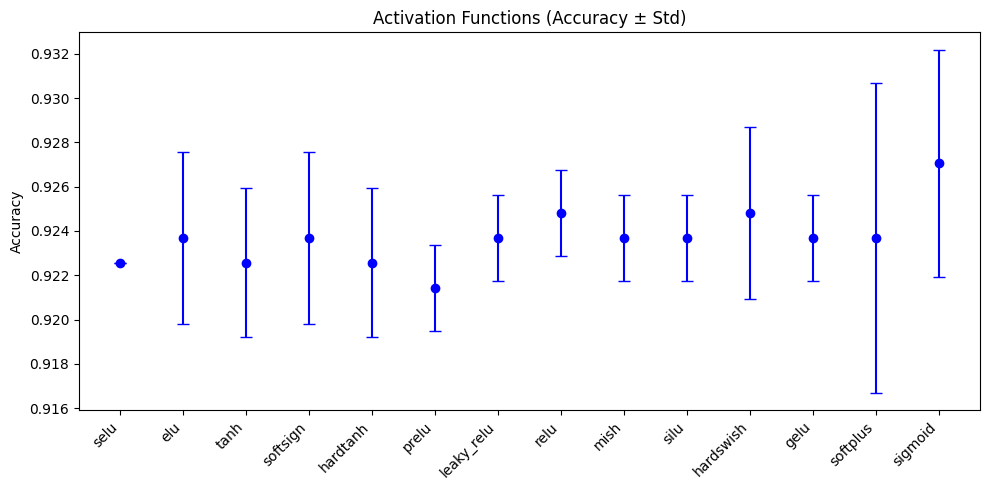

In [99]:
plt.figure(figsize=(10,5))
plt.errorbar(results_rep["activation"], results_rep["acc_mean"],
             yerr=results_rep["acc_std"], fmt="o", capsize=4, color="blue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Activation Functions (Accuracy ± Std)")
plt.tight_layout()
plt.show()


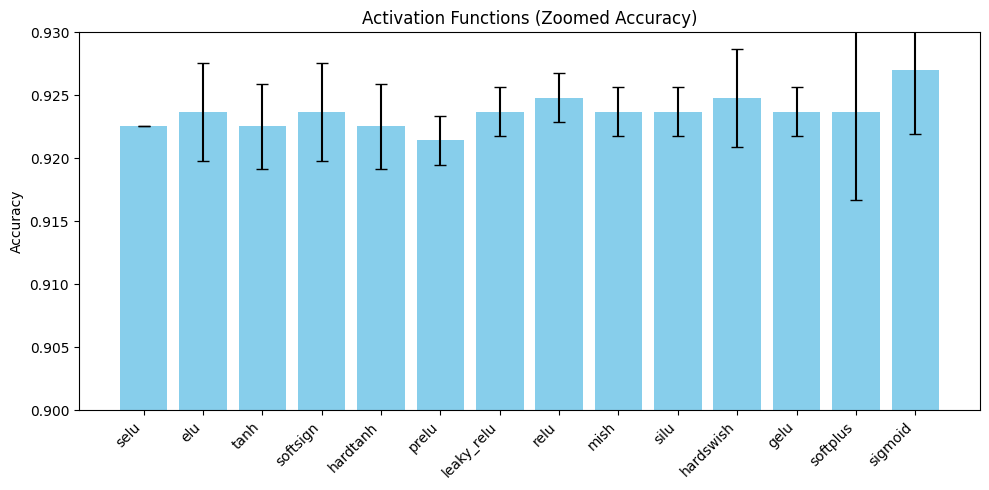

In [100]:
plt.figure(figsize=(10,5))
plt.bar(results_rep["activation"], results_rep["acc_mean"],
        yerr=results_rep["acc_std"], capsize=4, color="skyblue")
plt.ylim(0.90, 0.93)  # y-axis zoom-in
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Activation Functions (Zoomed Accuracy)")
plt.tight_layout()
plt.show()


In [101]:
#Learning

In [42]:
"""
Understanding Performance Differences Across Activation Functions
Functions like ReLU, GELU, SELU, and ELU are generally stable and deliver strong performance.
Functions such as Sigmoid and Softplus, which are older or suited for more specific contexts, tend to underperform.
"""

'\nUnderstanding Performance Differences Across Activation Functions\nFunctions like ReLU, GELU, SELU, and ELU are generally stable and deliver strong performance.\nFunctions such as Sigmoid and Softplus, which are older or suited for more specific contexts, tend to underperform.\n'

In [43]:
"""
Hands-on Experience With an Experimentation Workflow
SBERT embeddings → PyTorch MLP → train/evaluate → metric summary → repeated runs for mean/std → visualization.
Completing this end-to-end ML experiment pipeline is itself a valuable asset.
"""

'\nHands-on Experience With an Experimentation Workflow\nSBERT embeddings → PyTorch MLP → train/evaluate → metric summary → repeated runs for mean/std → visualization.\nCompleting this end-to-end ML experiment pipeline is itself a valuable asset.\n'

In [44]:
"""
Ability to Interpret Results
Instead of looking only at accuracy, you also evaluated F1 / AUC, which are more informative for imbalanced data.
Considering mean ± standard deviation helped you compare stability (variance) as well.
"""

'\nAbility to Interpret Results\nInstead of looking only at accuracy, you also evaluated F1 / AUC, which are more informative for imbalanced data.\nConsidering mean ± standard deviation helped you compare stability (variance) as well.\n'